In [1]:
import sys
import os
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
cm_seq2 = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.8, dark=0.1, as_cmap=True, reverse=False
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load data

In [4]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

(3000000, 2) (3000000, 60)


In [5]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [6]:
ivac_trajs = list(
    np.load("../../data/raw_feat/feat5_ivac_anton.npy", allow_pickle=True)
)
ivac_arr = np.concatenate(ivac_trajs)

In [7]:
ivac_arr.shape

(3000000, 10)

# Define states

In [8]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186
sb6 = sb_arr[:, 54]  # R232-D129


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

dist_ax_upp = (dist - 6.447) / 0.632
rot_ax_upp = (rot - 60.713) / 4.0
upplus_ids = ((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (sb6 < 1.0)

In [9]:
mask = ~(down_ids | up_ids)

# len(**_ids) is number of points in each state
down_sb = sb_arr[down_ids]
up_sb = sb_arr[up_ids]
other_sb = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_ivac = ivac_arr[down_ids]
up_ivac = ivac_arr[up_ids]
other_ivac = ivac_arr[~(down_ids | up_ids | upplus_ids)]

In [10]:
assert (len(down_sb) + len(up_sb) + len(other_sb)) == len(cv_arr)
print(f"Number of down structures:  {len(down_sb)}")
print(f"Number of up structures:   {len(up_sb)}")
print(f"Number of other structures: {len(other_sb)}")

Number of down structures:  29177
Number of up structures:   4614
Number of other structures: 2966209


# Cluster points outside of A and B

In [11]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors

In [12]:
k = 1000
kmeans = MiniBatchKMeans(k)
kmeans.fit(other_ivac)
centers = kmeans.cluster_centers_
neighbors = NearestNeighbors(n_neighbors=1)
neighbors.fit(centers)

NearestNeighbors(n_neighbors=1)

In [14]:
dtraj = neighbors.kneighbors(ivac_arr, return_distance=False)

In [15]:
dtraj.shape

(3000000, 1)

In [16]:
import random

random.seed(123)

In [17]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

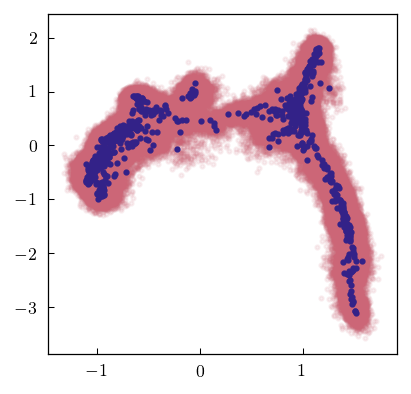

In [18]:
plt.scatter(ivac_arr[inds, 1], ivac_arr[inds, 2], alpha=0.1)
plt.scatter(centers[:, 1], centers[:, 2])

# Make bases

In [45]:
def domain_basis(basis, d):
    basis_d = np.where(d[:, None], basis, 0.0)
    mask = np.any(basis_d != 0.0, axis=0)
    return basis_d[:, mask]

In [46]:
n_basis = len(np.unique(dtraj))
basisF = np.zeros((len(cv_arr), n_basis))
basisF[np.arange(len(cv_arr)), dtraj.squeeze()] += 1.0

basisF = domain_basis(basisF, mask)

print(basisF.shape)

(3000000, 1000)


In [47]:
split_inds = util.split_indices(cv_trajs)
basisF = np.split(basisF, split_inds)

In [48]:
len(basisF), basisF[0].shape

(237, (10000, 1000))

[None]

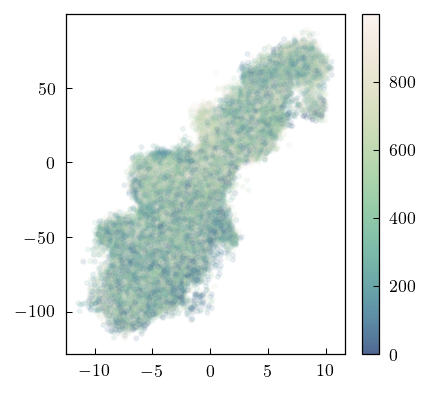

In [112]:
plt.scatter(cv_arr[inds, 0], cv_arr[inds, 1], c=dtraj[inds], alpha=0.1, cmap=cm_seq)
cb = plt.colorbar()
cb.solids.set(alpha=1)

# Committors

In [94]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [95]:
weights = np.load("../../data/coms_feat5_ind200_anton.npy", allow_pickle=True)[:10]

In [96]:
len(weights)

10

In [97]:
# PMFs
dist_trajs = [traj[:, 0] for traj in cv_trajs[:237]]
rot_trajs = [traj[:, 1] for traj in cv_trajs[:237]]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

In [98]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights[2], xlim, ylim)

/tmp/jobs/16494128/ipykernel_247669/221372391.py:9: RuntimeWarning: divide by zero encountered in log
  diff = -np.log(pmf.T) - min_energy


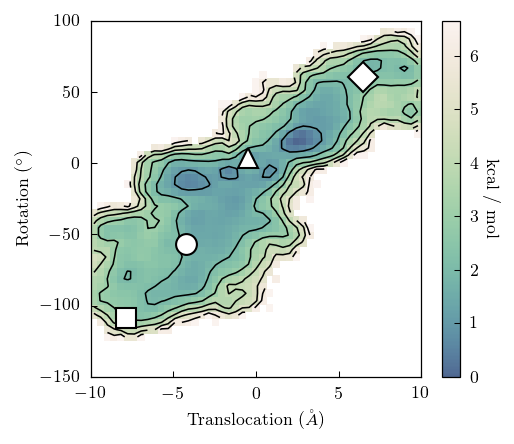

In [99]:
clines = np.linspace(0, 6, 7)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3))

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff * 0.593, cmap=cm_seq)
cb = plt.colorbar(h, ax=ax)
cb.set_label("kcal / mol", rotation=-90, labelpad=10)
ax.contour(centerx, centery, diff * 0.593, levels=clines, colors="black")
plotting.format_cvs(ax, centroids=True)
f.tight_layout()

In [100]:
weights[0].shape, weights[0][0].shape

((237,), (10000,))

In [101]:
d = np.split(mask, split_inds)
gp = np.split(up_ids.astype(float), split_inds)
gm = np.split(down_ids.astype(float), split_inds)

In [ ]:
qp_all, qm_all = [], []
for pi, lag in zip(weights, lags):
    print(f"Computing for lag {lag}")

    # forward committor
    qp = extq.dga.forward_committor(basisF, pi, d, gp, lag)
    qp_all.append(qp)

    # backward committor
    qm = extq.dga.backward_committor(basisF, pi, d, gm, lag)
    qm_all.append(qm)

Computing for lag 1
Computing for lag 2
Computing for lag 5
Computing for lag 10
Computing for lag 20
Computing for lag 50
Computing for lag 100
Computing for lag 200
Computing for lag 500
Computing for lag 1000


In [105]:
np.save("../../data/feat5_ivac_ind1000_recluster_du/qp", qp_all)
np.save("../../data/feat5_ivac_ind1000_recluster_du/qm", qm_all)

/project2/roux/scguo/anaconda/envs/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


## Plot

In [ ]:
random.seed(123)
N = len(cv_arr)
skip = 20
inds = random.sample(range(N), N // skip)

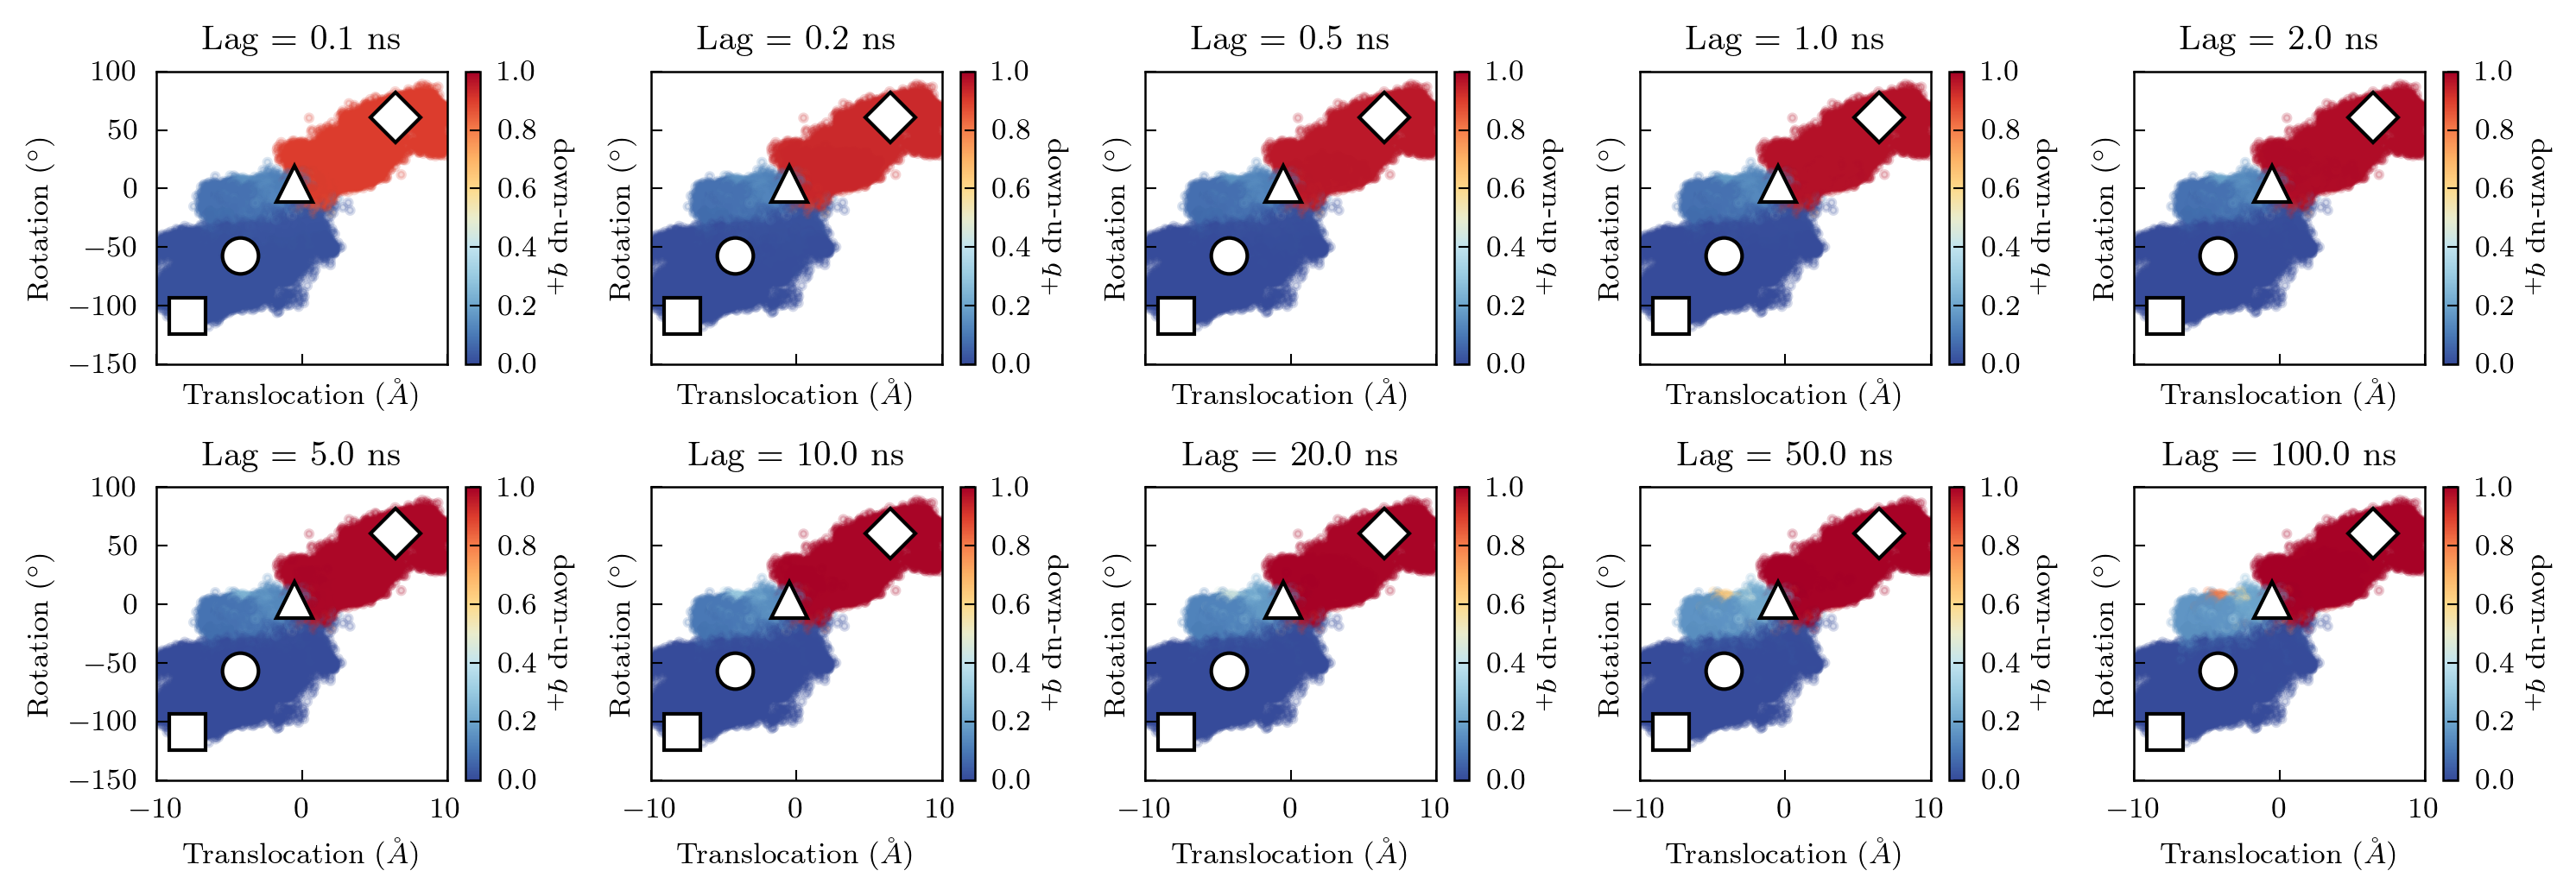

In [106]:
f, axs = plt.subplots(2, 5, figsize=(10, 3.5), sharex=True, sharey=True, dpi=300)
for lag, q, ax in zip(lags, qp_all, axs.flat):
    q_arr = np.concatenate(q)
    h = ax.scatter(*cv_arr[inds].T, c=q_arr[inds], cmap=cm_div, alpha=0.2)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    cbar.set_label("down-up $q_+$", rotation=-90, labelpad=10)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    plotting.format_cvs(ax, centroids=True)

f.tight_layout()

In [107]:
sb_ids = [42, 48, 47, 53]

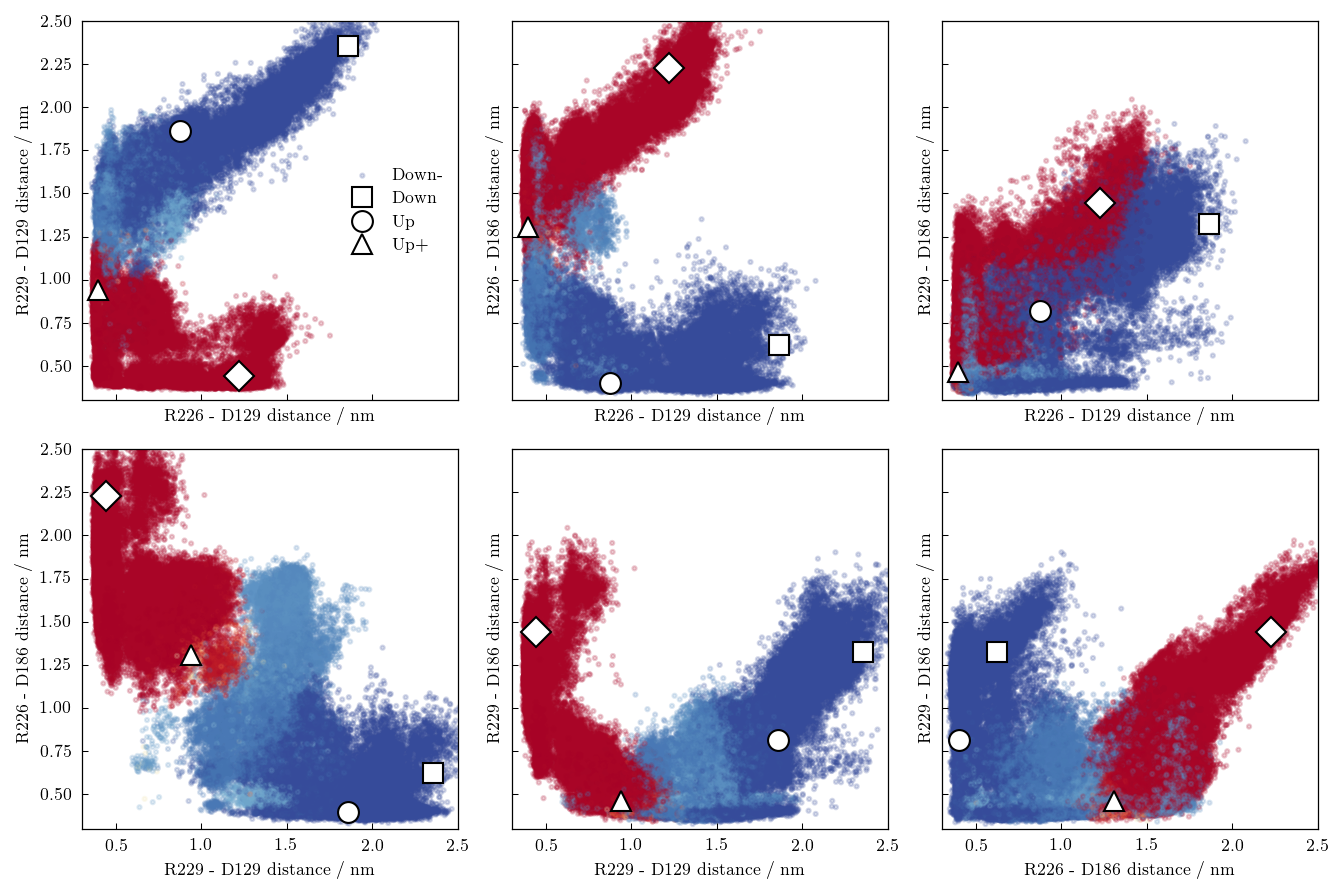

In [109]:
f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)

q_arr = np.concatenate(qp_all[6])
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    h = ax.scatter(
        sb_arr[inds, sb1], sb_arr[inds, sb2], c=q_arr[inds], cmap=cm_div, alpha=0.2
    )
    ax.set(
        xlabel=f"{sb_labels[sb1 - 30]} distance / nm",
        ylabel=f"{sb_labels[sb2 - 30]} distance / nm",
        xlim=[0.3, 2.5],
        ylim=[0.3, 2.5],
    )
# cbar = f.colorbar(h, ax=axes.ravel().tolist())
# cbar.solids.set(alpha=1)

plotting.plot_sb_models(axes.flat, mode="du", centroids=True)
axes[0][0].legend(["Down-", "Down", "Up", "Up+"], loc="right")

f.tight_layout()

In [113]:
centroids = np.loadtxt("../../models/MD-clustering-center/all.txt")

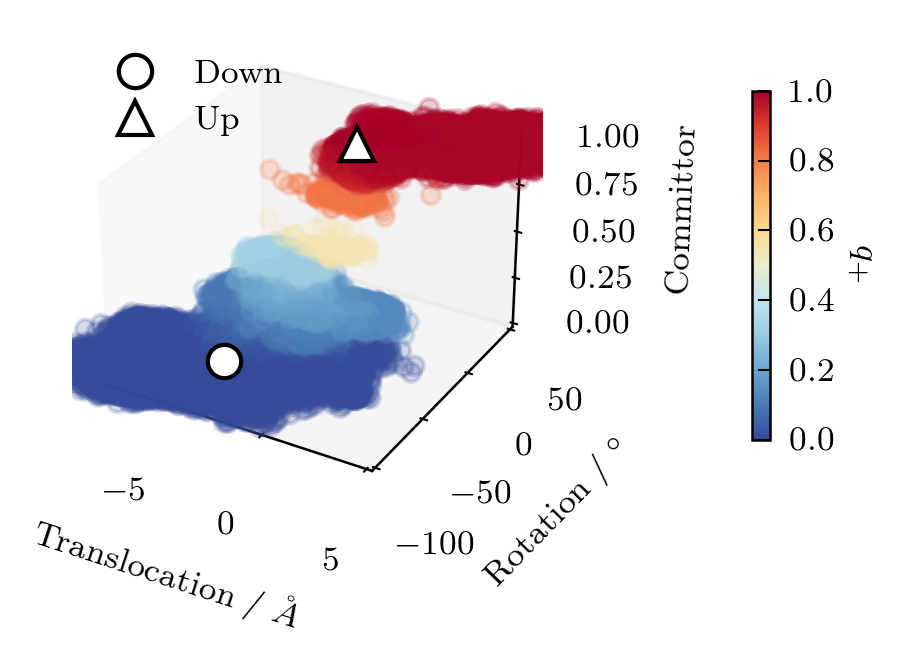

In [119]:
f = plt.figure(dpi=300)
ax = f.add_subplot(projection="3d")

q = np.concatenate(qp_all[6])
h = ax.scatter(
    cv_arr[inds, 0], cv_arr[inds, 1], q[inds], c=q[inds], cmap=cm_div, alpha=0.2
)
ax.set_xlabel("Translocation / $\AA$")
ax.set_ylabel("Rotation / $^\circ$")
ax.set_zlabel("Committor")
ax.set_xlim([-7.5, 5])
ax.set_ylim([-100, 50])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.30, fraction=0.025, label="$q_+$")
cbar.solids.set(alpha=1)
cbar.set_label("$q_+$", rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 10 ns lag')

ax.plot(
    centroids[1, 0],
    centroids[1, 1],
    0,
    "o",
    mec="k",
    mfc="w",
    ms=8,
    label="Down",
    zorder=3,
)
ax.plot(
    centroids[2, 0],
    centroids[2, 1],
    1,
    "^",
    mec="k",
    mfc="w",
    ms=8,
    label="Up",
    zorder=3,
)
ax.legend(loc="upper left")

In [120]:
feat2_models = np.load("../../data/models_centroids_feat2.npy")

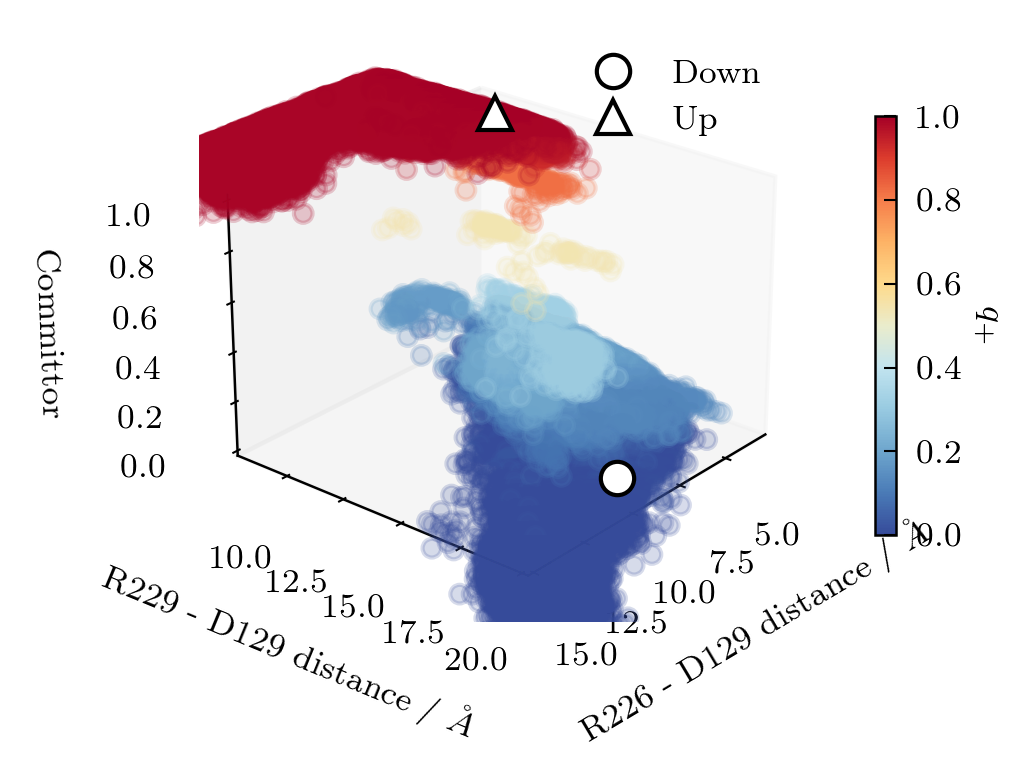

In [121]:
f = plt.figure(dpi=300)
ax = f.add_subplot(projection="3d")

ax.scatter(
    sb_arr[inds, sb_ids[0]] * 10,
    sb_arr[inds, sb_ids[1]] * 10,
    q[inds],
    c=q[inds],
    cmap=cm_div,
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]} distance / $\AA$")
ax.set_ylabel(f"{sb_labels[sb_ids[1] - 30]} distance / $\AA$")
ax.set_zlabel("Committor")
ax.set_xlim([3, 15])
ax.set_ylim([8, 20])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.12, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
cbar.set_label("$q_+$", rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 20 ns lag')

ax.plot(
    feat2_models[1, sb_ids[0]] * 10,
    feat2_models[1, sb_ids[1]] * 10,
    0,
    "o",
    mec="k",
    mfc="w",
    ms=8,
    label="Down",
    zorder=3,
)
ax.plot(
    feat2_models[2, sb_ids[0]] * 10,
    feat2_models[2, sb_ids[1]] * 10,
    1,
    "^",
    mec="k",
    mfc="w",
    ms=8,
    label="Up",
    zorder=3,
)
ax.legend(loc="upper right")

ax.view_init(azim=40, elev=25)

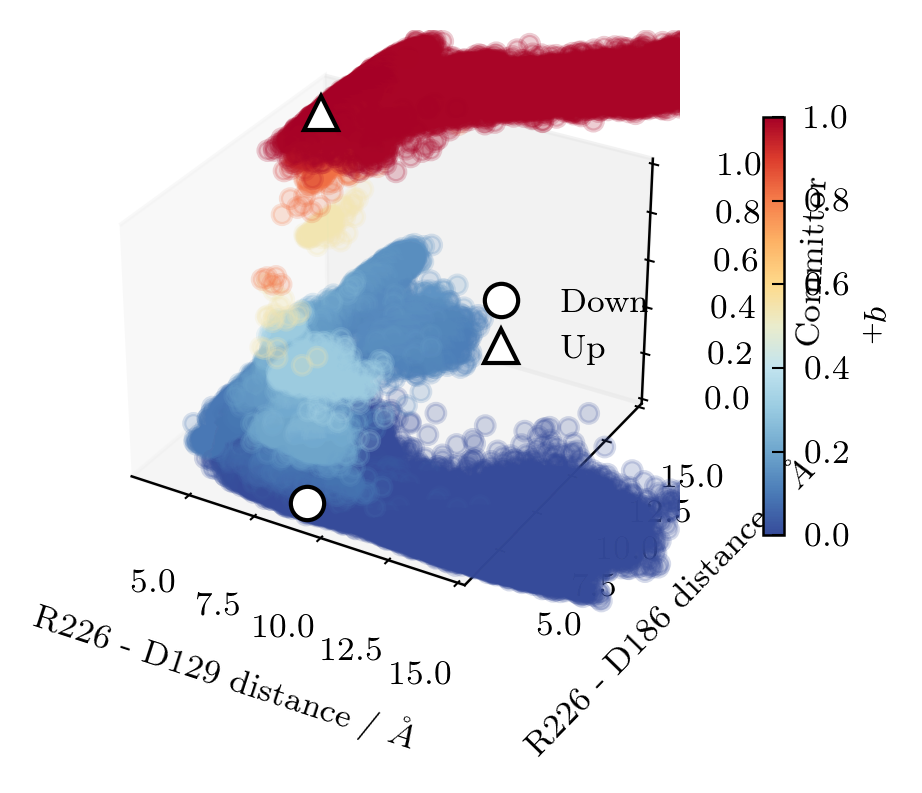

In [122]:
f = plt.figure(dpi=300)
ax = f.add_subplot(projection="3d")

ax.scatter(
    sb_arr[inds, sb_ids[0]] * 10,
    sb_arr[inds, sb_ids[2]] * 10,
    q[inds],
    c=q[inds],
    cmap=cm_div,
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]} distance / $\AA$")
ax.set_ylabel(f"{sb_labels[sb_ids[2] - 30]} distance / $\AA$")
ax.set_zlabel("Committor")
ax.set_xlim([3, 15])
ax.set_ylim([3, 15])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.12, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
cbar.set_label("$q_+$", rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 20 ns lag')

ax.plot(
    feat2_models[1, sb_ids[0]] * 10,
    feat2_models[1, sb_ids[2]] * 10,
    0,
    "o",
    mec="k",
    mfc="w",
    ms=8,
    label="Down",
    zorder=3,
)
ax.plot(
    feat2_models[2, sb_ids[0]] * 10,
    feat2_models[2, sb_ids[2]] * 10,
    1,
    "^",
    mec="k",
    mfc="w",
    ms=8,
    label="Up",
    zorder=3,
)
ax.legend(loc="right")

# ax.view_init(azim=40, elev=25)